In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.image as mpim
import matplotlib.animation as animation

#open files
file = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NumuSelection_Modern_Uboone_Lite.root")
file2 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Numu_Lite.root")
file3 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Nu_Osc_Lite.root") 
file4 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Intrinsic_Nue_Lite.root")

#grab the "protons on target" measurement for each dataset
pot = file["totpot"].member("fElements")[0] 
pot2 = file2["totpot"].member("fElements")[0]
pot3 = file3["totpot"].member("fElements")[0]
pot4 = file4["totpot"].member("fElements")[0]

#unpack each file and grab the relevant variables
Numu_cc = file["tree_numu_cc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Numu_nc = file["tree_numu_nc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Numu = file2["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_NuOsc = file3["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Intrinsic = file4["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")

# doing our "final" weight calculation:
# weights = desired POT * simulated_weights / simulated_POT
des_pot = 1.2e+21
# using 1.2e21 as our desired POT as the ~total beam collected over microboone's lifetime
Numu_cc["pot_weight"] = Numu_cc["weight"] * (des_pot / pot)
Numu_nc["pot_weight"] = Numu_nc["weight"] * (des_pot / pot)
Nue_Numu["pot_weight"] = Nue_Numu["weight"] * (des_pot / pot2)
Nue_NuOsc["pot_weight"] = Nue_NuOsc["weight"] * (des_pot / pot3)
Nue_Intrinsic["pot_weight"] = Nue_Intrinsic["weight"] * (des_pot / pot4)


#split datasets into neutrino types
cc_mu = Numu_cc[(Numu_cc["nu_pdg"] == 14.0)]
cc_mua = Numu_cc[(Numu_cc["nu_pdg"] == -14.0)]
nc_mu = Numu_nc[(Numu_nc["nu_pdg"] == 14.0)]
nc_mua = Numu_nc[(Numu_nc["nu_pdg"] == -14.0)]
osc_e = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == 12.0)]
osc_ea = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == -12.0)]
intrin_e = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == 12.0)]
intrin_ea = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == -12.0)]

/tmp/ipykernel_664590/4021996482.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# probability for mu->e, e->e, and mu->mu oscillations
# in terms of Ue4, Um4, and deltam2_41
def prob_energy(params, deltam_41, L_E, Paa="mue", sin2s=False):
    if (sin2s==False):
        Ue4, Um4 = params
    
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            probab = ((4*(Ue4**2)*(Um4)**2) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            probab =  1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            probab = 1 - ((4*(Um4**2)*(1-(Um4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    else:
        sin2_14, sin2_24 = params
        
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            # sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
            probab = (0.25 * sin2_14 * sin2_24) * (np.sin(1.27*deltam_41*L_E))**2
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            # sin2(2*theta_ee) ~= sin2(2*theta_14)
            probab =  1 - ((sin2_14) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            # sin2(2*theta_mumu) ~= sin2(2*theta_24)
            probab = 1 - ((sin2_24) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    return(probab)


In [19]:
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

variable_bins = np.array([0.16, 0.46, 0.76, 1.06, 1.36, 1.66, 1.96, 2.26, 2.56, 2.86, 3.16, 3.46, 3.76, 4.06, 6.00])
bins_widths = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.94])
bin_centers = np.array([0.31, 0.61, 0.91, 1.21, 1.51, 1.81, 2.11, 2.41, 2.71, 3.01, 3.31, 3.61, 3.91, 5.03])

#unosc_intrinisc_nue_mc and fullosc_mc AND unosc_intrinsic_numu_mc
def osc_chi2(params, unosc_intrinsic_nue_mc, fullosc_mc,unosc_intrinsic_numu_mc, n=1, sin2s=False):
    if sin2s==False:
        deltam2, Ue4, Um4 = params
        nue_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee")
        nue_appearance_probs = prob_energy([Ue4, Um4], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
        numu_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_numu_mc["true_baseline"]/1000)/unosc_intrinsic_numu_mc["true_energy"], Paa="mumu")
        
    else:
        deltam2, sin2_14, sin2_24= params
        nue_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee", sin2s=True)
        nue_appearance_probs = prob_energy([sin2_14, sin2_24], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
        numu_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_numu_mc["true_baseline"]/1000)/unosc_intrinsic_numu_mc["true_energy"], Paa="mumu", sin2s=True)
        
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    numu_survival_weight = unosc_intrinsic_numu_mc["pot_weight"] * numu_survival_probs
    
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    #plt.stairs(nue_intrinsic[0]/bins_widths, nue_intrinsic[1])
    #plt.show()
       
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    #now try adding the numu histogram
    numu_intrinsic = np.histogram(unosc_intrinsic_numu_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_numu_mc["pot_weight"]) #total intrinsic numu
    numu_survival = np.histogram(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], weights=numu_survival_weight) #intrinsic numu with oscillation disappearance
    
    #appending together nue and numu
    intrinsic_nu = np.concatenate([nue_intrinsic[0], numu_intrinsic[0]])
    signal_nu = np.concatenate([nue_survival[0]+nue_appearance[0], numu_survival[0]])
    
#     nue_chi2_val = chi2(nue_intrinsic[0], nue_survival[0]+nue_appearance[0], dof_normalize=False, subtract_from_dof=3, error="correlated")
#     numu_chi2_val = chi2(numu_intrinsic[0], numu_survival[0], dof_normalize=False, subtract_from_dof=3, error="correlated")
#     total_chi2_val = chi2(intrinsic_nu, signal_nu, dof_normalize=False, subtract_from_dof=3, error="correlated")
    
    #if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        # plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
        # plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
        # plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
        # plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
        # plt.legend()
        # plt.ylabel("Events")
        # plt.xlabel("Energy {GeV}")
        # plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        # plt.show()
        
    #plt.figure(figsize=(20,15))
    
    #plt.subplot(231)
    plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", edgecolor="black",histtype="barstacked", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="black", capsize=5)
    plt.ylabel("Events")
    plt.xlabel("True Energy {GeV}")
    plt.ylim((0,210))
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    if (sin2s==False):
        plt.title("Intrinsic $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))# + "\n$\\chi^2=$" + str(round(nue_chi2_val,5)))
    else:
        plt.title("Intrinsic $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))# + "\n$\\chi^2=$" + str(round(nue_chi2_val,5)))
    plt.show()
    
    #plt.subplot(232)
    plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label="Survival Nue", weights=nue_survival_weight)
    plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", edgecolor="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
    plt.errorbar(bin_centers, nue_survival[0], yerr= np.sqrt(nue_survival[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("True Energy {GeV}")
    plt.ylim((0,210))
    if (sin2s==False):
        plt.title("Intrinsic and Disappearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Disappearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    
    #plt.subplot(233)
    plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
    plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
    plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("True Energy {GeV}")
    plt.ylim((0,210))
    if (sin2s==False):
        plt.title("Intrinsic and Disappearance and Appearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Disappearance and Appearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    
    
    #plt.subplot(234)
    plt.hist(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black",color="coral" ,weights= unosc_intrinsic_numu_mc["pot_weight"], label="Unoscillated Intrinsic Numu")
    plt.errorbar(bin_centers,numu_intrinsic[0], yerr=np.sqrt(numu_intrinsic[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("True Energy {GeV}")
    if (sin2s==False):
        plt.title("Intrinsic $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    
    
    
    #plt.subplot(235)
    plt.hist(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], histtype="barstacked", color="green", edgecolor="black",weights = numu_survival_weight, label="Numu Survival")
    plt.hist(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], histtype="step",color="coral", weights= unosc_intrinsic_numu_mc["pot_weight"], label="Unoscillated Intrinsic Numu")
    plt.errorbar(bin_centers,numu_intrinsic[0], yerr=np.sqrt(numu_intrinsic[0]), fmt=" ", color="coral", capsize=5)
    plt.errorbar(bin_centers, numu_survival[0], yerr= np.sqrt(numu_survival[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("True Energy {GeV}")
    if (sin2s==False):
        plt.title("Intrinsic and Disappearance $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Disappearance $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    #plt.subplot(236)
    plt.plot(intrinsic_nu, label="intrinsic", color="salmon")
    print(intrinsic_nu.shape)
    plt.plot(signal_nu, label="signal", color="teal")
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.yscale("log")
    #plt.xticks([0,3.5,6.5,10,13,14,14.5,15,18.5,21.5,25,28], labels=[0,1,2,3,4,5,0,1,2,3,4,5])
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("$\\nu_e$ then $\\nu_\mu$ Energies")
    if (sin2s==False):
        plt.title("Intrinsic and Oscillated $\\nu_e$ and $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Oscillated $\\nu_e$ and $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    return
    return (nue_chi2_val, numu_chi2_val, total_chi2_val)



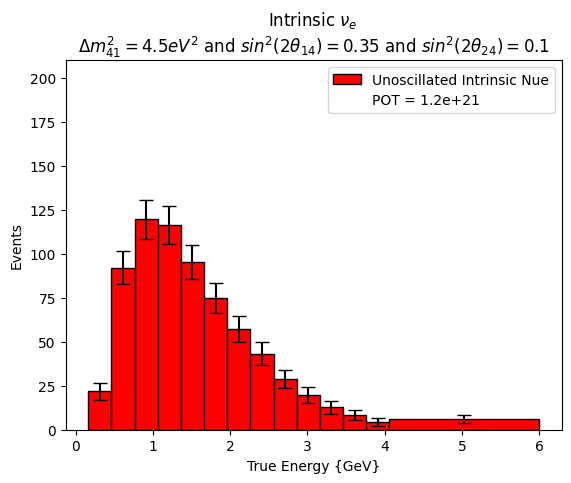

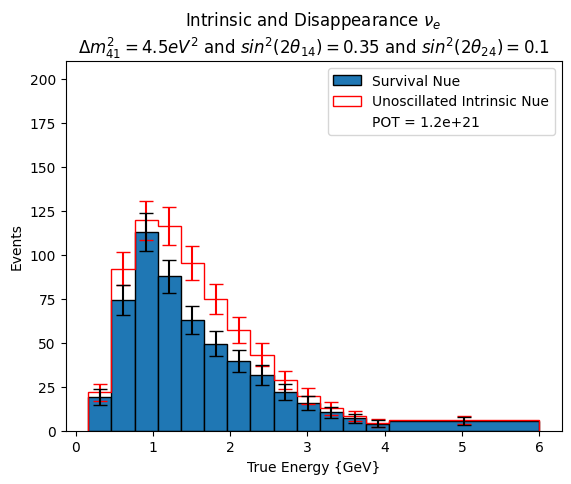

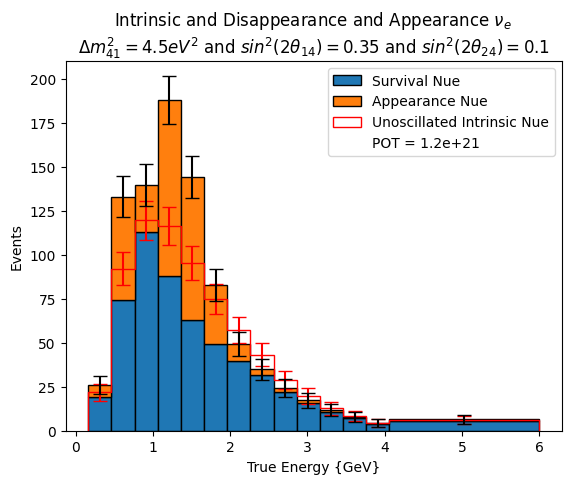

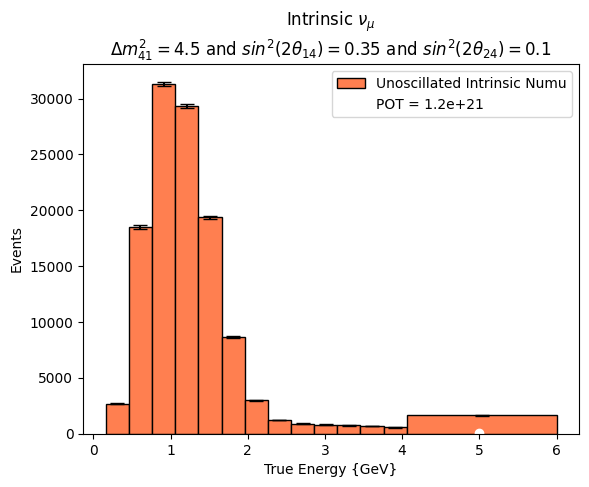

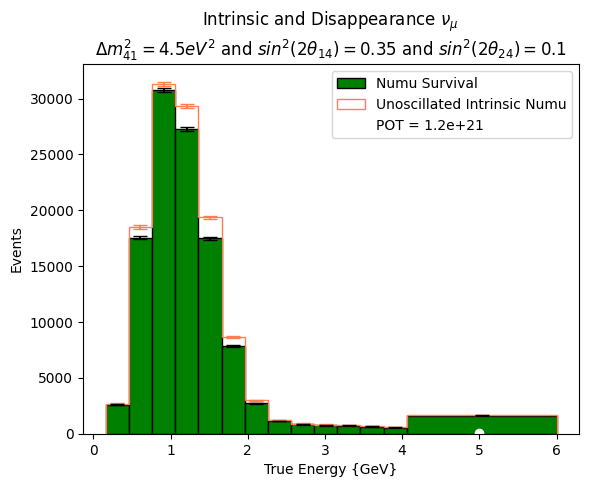

(28,)


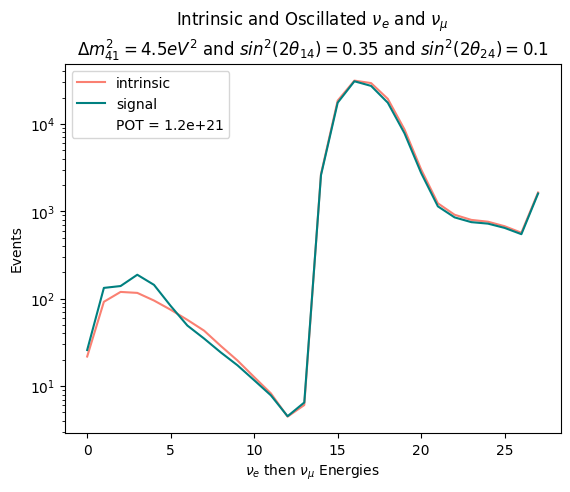

In [20]:
osc_chi2([4.5,0.35,0.1], intrin_e, osc_e, cc_mu, sin2s=True)

In [27]:
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

variable_bins = np.array([0.16, 0.46, 0.76, 1.06, 1.36, 1.66, 1.96, 2.26, 2.56, 2.86, 3.16, 3.46, 3.76, 4.06, 6.00])
bins_widths = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.94])
bin_centers = np.array([0.31, 0.61, 0.91, 1.21, 1.51, 1.81, 2.11, 2.41, 2.71, 3.01, 3.31, 3.61, 3.91, 5.03])

#unosc_intrinisc_nue_mc and fullosc_mc AND unosc_intrinsic_numu_mc
def osc_chi2_reco(params, unosc_intrinsic_nue_mc, fullosc_mc,unosc_intrinsic_numu_mc, n=1, sin2s=False):
    if sin2s==False:
        deltam2, Ue4, Um4 = params
        nue_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee")
        nue_appearance_probs = prob_energy([Ue4, Um4], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
        numu_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_numu_mc["true_baseline"]/1000)/unosc_intrinsic_numu_mc["true_energy"], Paa="mumu")
        
    else:
        deltam2, sin2_14, sin2_24= params
        nue_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee", sin2s=True)
        nue_appearance_probs = prob_energy([sin2_14, sin2_24], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
        numu_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_numu_mc["true_baseline"]/1000)/unosc_intrinsic_numu_mc["true_energy"], Paa="mumu", sin2s=True)
        
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    numu_survival_weight = unosc_intrinsic_numu_mc["pot_weight"] * numu_survival_probs
    
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["reco_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    #plt.stairs(nue_intrinsic[0]/bins_widths, nue_intrinsic[1])
    #plt.show()
       
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["reco_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["reco_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    #now try adding the numu histogram
    numu_intrinsic = np.histogram(unosc_intrinsic_numu_mc["reco_energy"], bins=variable_bins, weights=unosc_intrinsic_numu_mc["pot_weight"]) #total intrinsic numu
    numu_survival = np.histogram(unosc_intrinsic_numu_mc["reco_energy"], bins=nue_intrinsic[1], weights=numu_survival_weight) #intrinsic numu with oscillation disappearance
    
    #appending together nue and numu
    intrinsic_nu = np.concatenate([nue_intrinsic[0], numu_intrinsic[0]])
    signal_nu = np.concatenate([nue_survival[0]+nue_appearance[0], numu_survival[0]])
    
#     nue_chi2_val = chi2(nue_intrinsic[0], nue_survival[0]+nue_appearance[0], dof_normalize=False, subtract_from_dof=3, error="correlated")
#     numu_chi2_val = chi2(numu_intrinsic[0], numu_survival[0], dof_normalize=False, subtract_from_dof=3, error="correlated")
#     total_chi2_val = chi2(intrinsic_nu, signal_nu, dof_normalize=False, subtract_from_dof=3, error="correlated")
    
    #if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        # plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
        # plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
        # plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
        # plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
        # plt.legend()
        # plt.ylabel("Events")
        # plt.xlabel("Energy {GeV}")
        # plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        # plt.show()
        
    #plt.figure(figsize=(20,15))
    
    #plt.subplot(231)
    plt.hist(unosc_intrinsic_nue_mc["reco_energy"], bins=nue_intrinsic[1], color="red", edgecolor="black",histtype="barstacked", label="Unoscillated Intrinsic $\\nu_e$", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="black", capsize=5)
    plt.ylabel("Events")
    plt.xlabel("Reconstructed Energy {GeV}")
    plt.ylim((0,210))
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    if (sin2s==False):
        plt.title("Intrinsic $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))# + "\n$\\chi^2=$" + str(round(nue_chi2_val,5)))
    else:
        plt.title("Intrinsic $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))# + "\n$\\chi^2=$" + str(round(nue_chi2_val,5)))
    plt.show()
    
    #plt.subplot(232)
    plt.hist(unosc_intrinsic_nue_mc["reco_energy"], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label="Survival $\\nu_e$", weights=nue_survival_weight)
    plt.hist(unosc_intrinsic_nue_mc["reco_energy"], bins=nue_intrinsic[1], color="red", edgecolor="red", histtype="step", label="Unoscillated Intrinsic $\\nu_e$", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
    plt.errorbar(bin_centers, nue_survival[0], yerr= np.sqrt(nue_survival[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Reconstructed Energy {GeV}")
    plt.ylim((0,210))
    if (sin2s==False):
        plt.title("Intrinsic and Disappearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Disappearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    
    #plt.subplot(233)
    plt.hist([unosc_intrinsic_nue_mc["reco_energy"], fullosc_mc["reco_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Survival $\\nu_e$","Appearance $\\nu_e$"], weights=[nue_survival_weight,nue_appearance_weight])
    plt.hist(unosc_intrinsic_nue_mc["reco_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic $\\nu_e$", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
    plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Reconstructed Energy {GeV}")
    plt.ylim((0,210))
    if (sin2s==False):
        plt.title("Intrinsic and Disappearance and Appearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Disappearance and Appearance $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    
    
    #plt.subplot(234)
    plt.hist(unosc_intrinsic_numu_mc["reco_energy"], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black",color="coral" ,weights= unosc_intrinsic_numu_mc["pot_weight"], label="Unoscillated Intrinsic $\\nu_{\\mu}$")
    plt.errorbar(bin_centers,numu_intrinsic[0], yerr=np.sqrt(numu_intrinsic[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Reconstructed Energy {GeV}")
    if (sin2s==False):
        plt.title("Intrinsic $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    
    
    
    #plt.subplot(235)
    plt.hist(unosc_intrinsic_numu_mc["reco_energy"], bins=nue_intrinsic[1], histtype="barstacked", color="green", edgecolor="black",weights = numu_survival_weight, label="$\\nu_{\\mu}$ Survival")
    plt.hist(unosc_intrinsic_numu_mc["reco_energy"], bins=nue_intrinsic[1], histtype="step",color="coral", weights= unosc_intrinsic_numu_mc["pot_weight"], label="Unoscillated Intrinsic $\\nu_{\\mu}$")
    plt.errorbar(bin_centers,numu_intrinsic[0], yerr=np.sqrt(numu_intrinsic[0]), fmt=" ", color="coral", capsize=5)
    plt.errorbar(bin_centers, numu_survival[0], yerr= np.sqrt(numu_survival[0]), fmt=" ", color="black", capsize=5)
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Reconstructed Energy {GeV}")
    if (sin2s==False):
        plt.title("Intrinsic and Disappearance $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Disappearance $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + "$eV^2$ and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    #plt.subplot(236)
    plt.plot(intrinsic_nu, label="intrinsic", color="salmon")
    print(intrinsic_nu.shape)
    plt.plot(signal_nu, label="signal", color="teal")
    plt.scatter(5,100,color="white",label="POT = 1.2e+21")
    plt.yscale("log")
    #plt.xticks([0,3.5,6.5,10,13,14,14.5,15,18.5,21.5,25,28], labels=[0,1,2,3,4,5,0,1,2,3,4,5])
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("$\\nu_e$ then $\\nu_\mu$ Reconstructed Energies")
    if (sin2s==False):
        plt.title("Intrinsic and Oscillated $\\nu_e$ and $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)))
    else:
        plt.title("Intrinsic and Oscillated $\\nu_e$ and $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24))
    plt.show()
    
    return
    return (nue_chi2_val, numu_chi2_val, total_chi2_val)



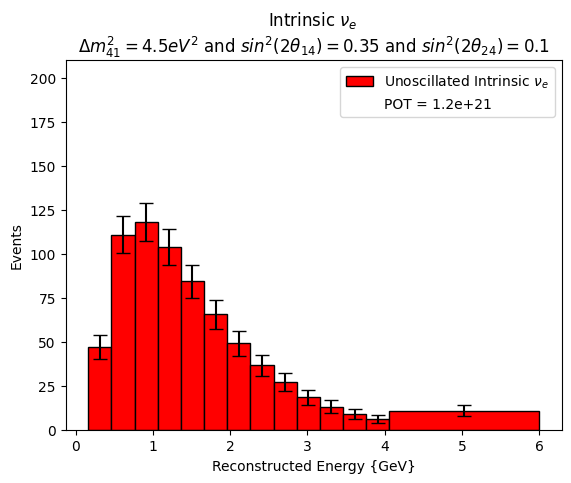

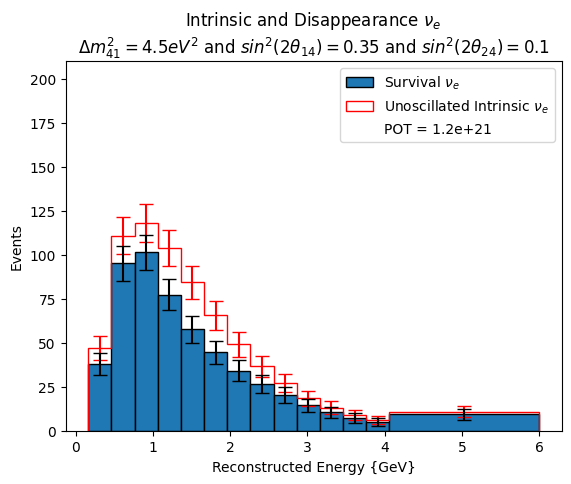

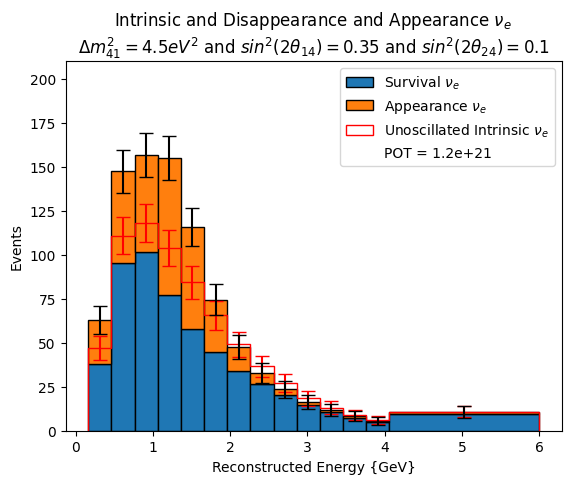

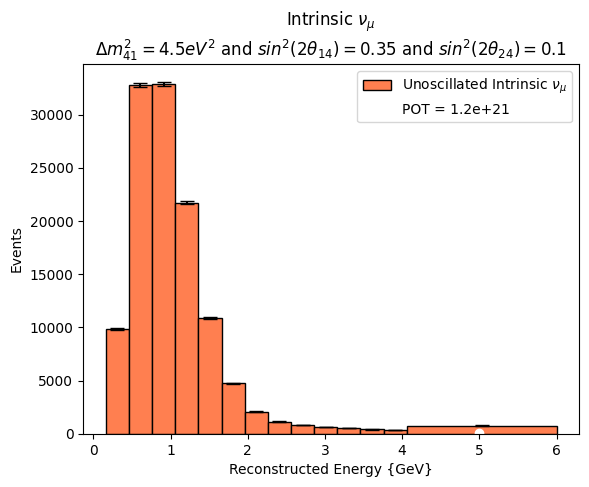

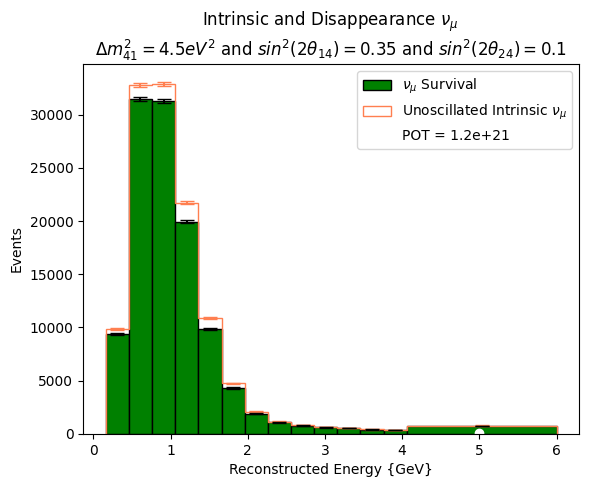

(28,)


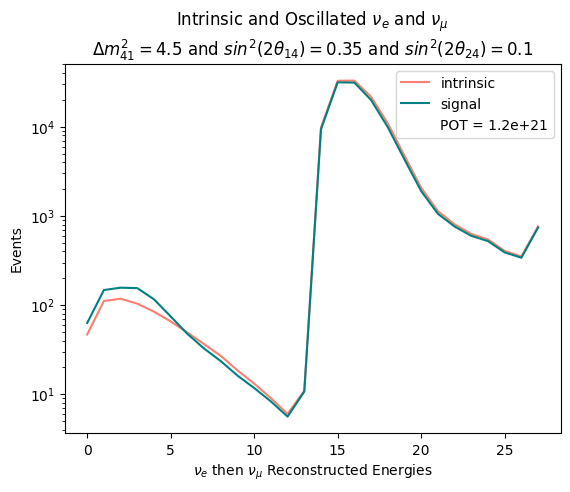

In [28]:
osc_chi2_reco([4.5,0.35,0.1], intrin_e, osc_e, cc_mu, sin2s=True)